<a href="https://colab.research.google.com/github/SojeongShin/NLP_2023/blob/main/12_1_RNN%EC%9D%84_%EC%9D%B4%EC%9A%A9%ED%95%9C_%EB%AC%B8%EC%84%9C_%EB%B6%84%EB%A5%98(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [자연어처리]
# 12주차(12-1). RNN을 이용한 문서 분류(2)

# 202001581 신소정 <- 본인의 학번, 이름으로 변경하여 제출
* **모든 셀 실행** 후 제출하시기 바랍니다.
* **실습 (12-1)**이 있습니다. (제출 기한: 11/21(화) 23시 59분까지)

# 이제 Colab 사용에 모든 수강생분들이 어느정도 익숙해 졌을 거라 생각됩니다!
> ##### 중간 중간 **'### ... 이 부분을 완성하시오'** 라는 부분의 코드를 완성해야 합니다.




링크 : https://wikidocs.net/44249

In [5]:
import tensorflow as tf
tf.__version__

'2.14.0'

In [6]:
pip install konlpy

# 1. 네이버 영화 리뷰 데이터에 대한 이해와 전처리

In [7]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
from konlpy.tag import Komoran
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1) 데이터 로드하기

링크로부터 훈련 데이터에 해당하는 ratings_train.txt와 테스트 데이터에 해당하는 ratings_test.txt를 다운로드합니다.

In [4]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7ec2902e4760>)

pandas를 이용하여 훈련 데이터는 train_data에 테스트 데이터는 test_data에 저장합니다.

In [8]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

train_data에 존재하는 영화 리뷰의 개수를 확인해봅시다.

In [9]:
print('훈련 샘플의 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력
print('테스트 샘플의 개수 :',len(test_data)) # 테스트용 리뷰 개수 출력

훈련 샘플의 개수 : 150000
테스트 샘플의 개수 : 50000


train_data는 총 150,000개의 리뷰가 존재합니다. 상위 5개의 샘플을 출력해봅시다.

In [11]:
# 상위 5개 출력
train_data[:5]   ### ... 이 부분을 완성하시오

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


해당 데이터는 id, document, label 총 3개의 열로 구성되어져 있습니다. id는 감성 분류를 수행하는데 도움이 되지 않으므로 앞으로 무시합니다. 결국 이 모델은 리뷰 내용을 담고있는 document와 해당 리뷰가 긍정(1), 부정(0)인지를 나타내는 label 두 개의 열을 학습하는 모델이 되어야 합니다.

또한 단지 상위 5개의 샘플만 출력해보았지만 한국어 데이터와 영어 데이터의 차이를 확인할 수 있습니다. 예를 들어, 인덱스 2번 샘플은 띄어쓰기를 하지 않아도 글을 쉽게 이해할 수 있는 한국어의 특성으로 인해 띄어쓰기가 되어있지 않습니다.

## 2) 데이터 정제하기

train_data의 데이터 중복 유무를 확인합니다.

In [12]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

총 150,000개의 샘플이 존재하는데 document열에서 중복을 제거한 샘플의 개수가 146,182개라는 것은 약 4,000개의 중복 샘플이 존재한다는 의미입니다. label 열은 0 또는 1의 두 가지 값만을 가지므로 2가 출력됩니다. 중복 샘플을 제거합니다.

In [13]:
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거

중복 샘플을 제거하였습니다. 중복이 제거되었는지 전체 샘플 수를 확인합니다.

In [14]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


중복 샘플이 제거되었습니다. train_data에서 해당 리뷰의 긍, 부정 유무가 기재되어있는 레이블(label) 값의 분포를 보겠습니다.

<Axes: >

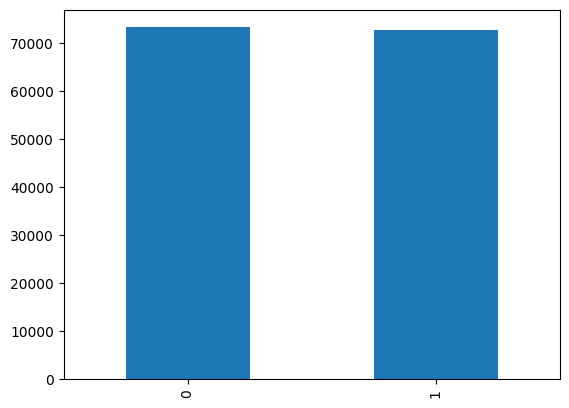

In [15]:
train_data['label'].value_counts().plot(kind = 'bar')

앞서 확인하였듯이 약 146,000개의 영화 리뷰 샘플이 존재하는데 그래프 상으로 긍정과 부정 둘 다 약 73,000개의 샘플이 존재하여 레이블의 분포가 균일한 것처럼 보입니다. 정확하게 몇 개인지 확인해봅시다.

In [16]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


레이블이 0인 리뷰가 근소하게 많습니다. 리뷰 중에 Null 값을 가진 샘플이 있는지 확인합니다.

In [17]:
print(train_data.isnull().values.any())

True


True가 나왔다면 데이터 중에 Null 값을 가진 샘플이 존재한다는 의미입니다. 어떤 열에 존재하는지 확인해봅시다.

In [18]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


리뷰가 적혀있는 document 열에서 Null 값을 가진 샘플이 총 1개가 존재한다고 합니다. 그렇다면 document 열에서 Null 값이 존재한다는 것을 조건으로 Null 값을 가진 샘플이 어느 인덱스의 위치에 존재하는지 한 번 출력해봅시다.

In [19]:
train_data.loc[train_data.document.isnull()]

,id,document,label
25857,2172111,NaN,1


출력 결과는 위와 같습니다. Null 값을 가진 샘플을 제거하겠습니다.

In [20]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


Null 값을 가진 샘플이 제거되었습니다. 다시 샘플의 개수를 출력하여 1개의 샘플이 제거되었는지 확인해봅시다.

In [21]:
print(len(train_data))

146182


데이터의 전처리를 수행해보겠습니다. 위의 train_data와 test_data에서 온점(.)이나 ?와 같은 각종 특수문자가 사용된 것을 확인했습니다. train_data로부터 한글만 남기고 제거하기 위해서 정규 표현식을 사용해보겠습니다.

위와 같은 원리를 한국어 데이터에 적용하고 싶다면, 우선 한글을 범위 지정할 수 있는 정규 표현식을 찾아내면 되겠습니다. 우선 자음과 모음에 대한 범위를 지정해보겠습니다. 일반적으로 자음의 범위는 ㄱ ~ ㅎ, 모음의 범위는 ㅏ ~ ㅣ와 같이 지정할 수 있습니다. 해당 범위 내에 어떤 자음과 모음이 속하는지 알고 싶다면 아래의 링크를 참고하시기 바랍니다.

링크 : https://www.unicode.org/charts/PDF/U3130.pdf
ㄱ ~ ㅎ: 3131 ~ 314E
ㅏ ~ ㅣ: 314F ~ 3163

완성형 한글의 범위는 가 ~ 힣과 같이 사용합니다. 해당 범위 내에 포함된 음절들은 아래의 링크에서 확인할 수 있습니다.

링크 : https://www.unicode.org/charts/PDF/UAC00.pdf
위 범위 지정을 모두 반영하여 train_data에 한글과 공백을 제외하고 모두 제거하는 정규 표현식을 수행해봅시다.

In [23]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace('^ +',"")    ### ... 이 부분을 완성하시오
train_data[:5]

<ipython-input-23-10a18fc3c35a>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +',"")    ### ... 이 부분을 완성하시오


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


상위 5개의 샘플을 다시 출력해보았는데, 정규 표현식을 수행하자 기존의 공백. 즉, 띄어쓰기는 유지되면서 온점과 같은 구두점 등은 제거되었습니다. 사실 네이버 영화 리뷰는 한글이 아니더라도 영어, 숫자, 특수문자로도 리뷰를 업로드할 수 있습니다. 다시 말해 기존에 한글이 없는 리뷰였다면 더 이상 아무런 값도 없는 빈(empty) 값이 되었을 것입니다. train_data에 공백(whitespace)만 있거나 빈 값을 가진 행이 있다면 Null 값으로 변경하도록 하고, Null 값이 존재하는지 확인해보겠습니다.

In [24]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

<ipython-input-24-c2f9538d5bc3>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


id          0
document    0
label       0
dtype: int64


Null 값이 789개나 새로 생겼습니다. Null 값이 있는 행을 5개만 출력해볼까요?

In [25]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label


Null 샘플들은 레이블이 긍정일 수도 있고, 부정일 수도 있습니다. 아무런 의미도 없는 데이터므로 제거해줍니다.

In [26]:
train_data = train_data.dropna(how = 'any')

In [27]:
print(len(train_data))

146182


샘플 개수가 또 다시 줄어서 145,393개가 남았습니다. 테스트 데이터에 앞서 진행한 전처리 과정을 동일하게 진행합니다.

In [28]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


<ipython-input-28-c182d8fa0991>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
<ipython-input-28-c182d8fa0991>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [29]:
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


## 3) 토큰화

토큰화를 진행해봅시다. 토큰화 과정에서 불용어를 제거하겠습니다. 불용어는 정의하기 나름인데, 한국어의 조사, 접속사 등의 보편적인 불용어를 사용할 수도 있겠지만 결국 풀고자 하는 문제의 데이터를 지속 검토하면서 계속해서 추가하는 경우 또한 많습니다. 실제 현업인 상황이라면 일반적으로 아래의 불용어보다 더 많은 불용어를 사용할 수 있습니다.

In [30]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

여기서는 위 정도로만 불용어를 정의하고, 토큰화를 위한 형태소 분석기는 KoNLPy의 Komoran을 사용합니다.

In [31]:
komoran = Komoran()

train_data에 형태소 분석기를 사용하여 토큰화를 하면서 불용어를 제거하여 X_train에 저장합니다.

In [33]:
X_train = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = komoran.morphs(sentence) # 토큰화     ### ... 이 부분을 완성하시오
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|██████████| 146182/146182 [01:54<00:00, 1281.05it/s]


In [34]:
X_test = []
for sentence in tqdm(test_data['document']):
    tokenized_sentence = komoran.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 48852/48852 [00:39<00:00, 1236.94it/s]


지금까지 훈련 데이터와 테스트 데이터에 대해서 텍스트 전처리를 진행해보았습니다.

In [35]:
print('전처리 후 테스트용 샘플의 개수 :',len(X_test))

전처리 후 테스트용 샘플의 개수 : 48852


## 4) 정수 인코딩

기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터에 정수 인코딩을 수행해야 합니다. 우선, 훈련 데이터에 대해서 단어 집합(vocaburary)을 만들어봅시다.

In [36]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다. 이는 tokenizer.word_index를 출력하여 확인 가능합니다.

In [37]:
print(tokenizer.word_index)

{'.': 1, '하': 2, 'ㄴ': 3, '영화': 4, '다': 5, '보': 6, '고': 7, '을': 8, '았': 9, '게': 10, '...': 11, '었': 12, 'ㄹ': 13, ',': 14, '어': 15, '지': 16, '아': 17, '?': 18, '있': 19, '나': 20, 'ㅁ': 21, '없': 22, '~': 23, '되': 24, '!': 25, '는데': 26, '만': 27, '좋': 28, '주': 29, '것': 30, '너무': 31, '적': 32, '정말': 33, '기': 34, '점': 35, '음': 36, 'ㄴ다': 37, '내': 38, '안': 39, '같': 40, '에서': 41, '로': 42, '..': 43, '진짜': 44, '재밌': 45, '지만': 46, '어요': 47, '네요': 48, '네': 49, '않': 50, '아니': 51, '만들': 52, '아서': 53, '말': 54, '수': 55, '연기': 56, '거': 57, '면': 58, '나오': 59, ';': 60, 'ㅂ니다': 61, '평점': 62, '최고': 63, '^': 64, '던': 65, '왜': 66, '뭐': 67, '그': 68, '겠': 69, '이런': 70, '스토리': 71, '생각': 72, '때': 73, '습니다': 74, '1': 75, '시': 76, '드라마': 77, '사람': 78, '배우': 79, '보다': 80, '더': 81, '감동': 82, '!!': 83, '싶': 84, '까지': 85, '알': 86, '라': 87, '어서': 88, '아깝': 89, '내용': 90, '오': 91, '감독': 92, '그냥': 93, '재': 94, '재미있': 95, '시간': 96, '중': 97, '듯': 98, '"': 99, '지루': 100, '재미': 101, '이렇': 102, '아도': 103, 'ㄴ데': 104, '쓰레기': 105, 'ㄴ가':

단어가 54,000개가 넘게 존재합니다. 각 정수는 전체 훈련 데이터에서 등장 빈도수가 높은 순서대로 부여되었기 때문에, 높은 정수가 부여된 단어들은 등장 빈도수가 매우 낮다는 것을 의미합니다. 여기서는 빈도수가 낮은 단어들은 자연어 처리에서 배제하고자 합니다. 등장 빈도수가 3회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

In [38]:
print(tokenizer.word_counts.items())

odict_items([('아', 20027), ('더빙', 560), ('.', 112555), ('진짜', 7901), ('짜증', 1433), ('나', 15273), ('네요', 7765), ('목소리', 361), ('흠', 232), ('...', 25385), ('포스터', 538), ('보고', 1436), ('초딩', 404), ('영화', 52327), ('줄', 1709), ('....', 2310), ('오버', 135), ('연기', 7046), ('조차', 306), ('가볍', 356), ('지', 20949), ('않', 7648), ('구나', 749), ('너무재밓었다그래서보는것을추천한다', 1), ('교도소', 17), ('이야기', 2128), ('구먼', 40), ('..', 7920), ('솔직히', 1056), ('재미', 3618), ('없', 15207), ('다', 52079), ('평점', 6107), ('조정', 37), ('사이몬페그의', 1), ('익살', 11), ('스럽', 2460), ('ㄴ', 71504), ('돋보이', 287), ('었', 24999), ('던', 5746), ('!', 12377), ('스파이더맨', 54), ('에서', 7984), ('늙', 192), ('어', 21614), ('보이', 2785), ('기', 9485), ('만', 11403), ('하', 94268), ('았', 29180), ('커스틴 던스트', 2), ('너무나', 703), ('이뻐보였다', 1), ('막', 462), ('걸음마', 2), ('떼', 184), ('3', 2288), ('세', 1160), ('부터', 1934), ('초등학교', 113), ('1', 5071), ('학년', 138), ('생', 473), ('8살용영화.ㅋㅋㅋ...별반개도', 1), ('아깝', 4157), ('ㅁ', 15235), ('원작', 1312), ('긴장감', 818), ('을', 29379), ('제대

In [39]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 59869
등장 빈도가 2번 이하인 희귀 단어의 수: 41319
단어 집합에서 희귀 단어의 비율: 69.01568424393258
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.9122457817509775


등장 빈도가 threshold 값인 3회 미만. 즉, 2회 이하인 단어들은 단어 집합에서 무려 절반 이상을 차지합니다. 하지만, 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 1.93%밖에 되지 않습니다. 아무래도 등장 빈도가 2회 이하인 단어들은 자연어 처리에서 별로 중요하지 않을 듯 합니다. 그래서 이 단어들은 정수 인코딩 과정에서 배제시키겠습니다.

등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한하겠습니다.

In [40]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 18551


단어 집합의 크기는 17,864개입니다. 이를 케라스 토크나이저의 인자로 넘겨주고 텍스트 시퀀스를 정수 시퀀스로 변환합니다.

In [41]:
tokenizer = Tokenizer(vocab_size) # 빈도수 2 이하인 단어는 제거
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [42]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [43]:
print(len(X_train))
print(len(y_train))

146182
146182


In [44]:
print(X_train[:3])

[[17, 518, 1, 1, 44, 230, 20, 48, 750], [1028, 11, 540, 227, 699, 4, 197, 146, 1528, 56, 850, 755, 16, 50, 401], []]


각 샘플 내의 단어들은 각 단어에 대한 정수로 변환된 것을 확인할 수 있습니다. 단어의 개수는 17,864개로 제한되었으므로 0번 단어 ~ 17,863번 단어까지만 사용 중입니다. 0번 단어는 패딩을 위한 토큰임을 상기합시다. train_data에서 y_train과 y_test를 별도로 저장해줍니다 .

## 5) 빈 샘플(empty samples) 제거

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 빈(empty) 샘플이 되었다는 것을 의미합니다. 빈 샘플들은 어떤 레이블이 붙어있던 의미가 없으므로 빈 샘플들을 제거해주는 작업을 하겠습니다. 각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스를 받아오겠습니다.

In [46]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
drop_test = [index for index, sentence in enumerate(X_test) if len(sentence) < 1]

In [47]:
print(drop_train)

[2, 10, 28, 208, 252, 319, 489, 549, 624, 668, 734, 755, 765, 804, 851, 926, 1031, 1036, 1047, 1068, 1075, 1152, 1201, 1211, 1220, 1287, 1300, 1543, 1555, 1582, 1695, 1721, 1771, 1814, 1842, 1912, 1916, 2159, 2167, 2179, 2214, 2228, 2251, 2319, 2360, 2398, 2447, 2497, 2575, 2587, 2590, 2613, 2685, 2701, 2847, 2919, 2997, 3110, 3113, 3173, 3200, 3252, 3259, 3264, 3360, 3380, 3405, 3415, 3433, 3470, 3583, 3584, 3615, 3640, 3665, 3670, 3712, 3898, 3902, 3933, 3934, 3992, 4096, 4216, 4269, 4312, 4347, 4376, 4454, 4624, 4648, 4713, 4716, 4718, 4732, 4781, 4784, 4911, 5221, 5311, 5337, 5446, 5502, 5541, 5666, 5688, 5760, 5916, 5936, 5941, 6001, 6135, 6144, 6176, 6256, 6271, 6367, 6455, 6460, 6475, 6504, 6548, 6628, 6631, 6731, 6748, 6759, 6813, 6844, 6922, 7020, 7187, 7273, 7416, 7587, 7591, 7727, 7953, 7973, 8080, 8128, 8177, 8253, 8324, 8329, 8343, 8366, 8392, 8425, 8464, 8497, 8616, 8627, 8640, 8716, 8725, 8767, 8822, 8848, 8896, 9000, 9009, 9025, 9034, 9127, 9128, 9277, 9396, 9499, 9524,

In [48]:
len(drop_train)

2552

In [49]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


drop_train에는 X_train으로부터 얻은 빈 샘플들의 인덱스가 저장됩니다. 앞서 훈련 데이터(X_train, y_train)의 샘플 개수는 145,393개임을 확인했었습니다. 그렇다면 빈 샘플들을 제거한 후의 샘플 개수는 몇 개일까요?

In [50]:
print(len(X_train))
print(len(y_train))

143630
143630


143,093개로 샘플의 수가 줄어든 것을 확인할 수 있습니다.

In [51]:
print(len(X_test))
print(len(y_test))

48852
48852


In [52]:
X_test = np.delete(X_test, drop_test, axis=0)

In [53]:
y_test = np.delete(y_test, drop_test, axis=0)

In [54]:
print(len(X_test))
print(len(y_test))

48096
48096


## 6) 패딩

서로 다른 길이의 샘플들의 길이를 동일하게 맞춰주는 패딩 작업을 진행해보겠습니다. 전체 데이터에서 가장 길이가 긴 리뷰와 전체 데이터의 길이 분포를 알아보겠습니다.

리뷰의 최대 길이 : 140
리뷰의 평균 길이 : 16.794736475666642


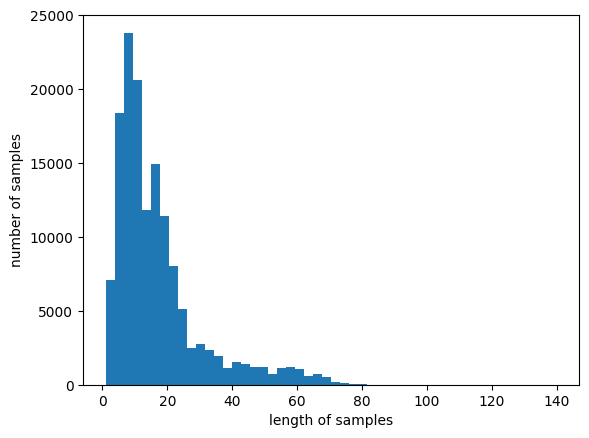

In [55]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

가장 긴 리뷰의 길이는 104이며, 그래프를 봤을 때 전체 데이터의 길이 분포는 대체적으로 약 15 내외의 길이를 가지는 것을 볼 수 있습니다. 모델이 처리할 수 있도록 X_train과 X_test의 모든 샘플의 길이를 특정 길이로 동일하게 맞춰줄 필요가 있습니다. 특정 길이 변수를 max_len으로 정합니다. 대부분의 리뷰가 내용이 잘리지 않도록 할 수 있는 최적의 max_len의 값은 몇일까요? 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수를 만듭니다.

In [56]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

위의 분포 그래프를 봤을 때, max_len = 30이 적당할 것 같습니다. 이 값이 얼마나 많은 리뷰 길이를 커버하는지 확인해봅시다.

In [57]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 87.51653554271391


전체 훈련 데이터 중 약 89%의 리뷰가 30이하의 길이를 가지는 것을 확인했습니다. 모든 샘플의 길이를 30으로 맞추겠습니다.

In [58]:
# 전체 데이터의 길이는 30으로 맞춘다.
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# 2. LSTM으로 네이버 영화 리뷰 감성 분류하기

하이퍼파라미터인 임베딩 벡터의 차원은 100, 은닉 상태의 크기는 128입니다. 모델은 다 대 일 구조의 LSTM을 사용합니다. 해당 모델은 마지막 시점에서 두 개의 선택지 중 하나를 예측하는 이진 분류 문제를 수행하는 모델입니다. 이진 분류 문제의 경우, 출력층에 로지스틱 회귀를 사용해야 하므로 활성화 함수로는 시그모이드 함수를 사용하고, 손실 함수로 크로스 엔트로피 함수를 사용합니다. 하이퍼파라미터인 배치 크기는 64이며, 10 에포크를 수행합니다.

validation_split=0.2을 사용하여 훈련 데이터의 20%를 검증 데이터로 분리해서 사용하고, 검증 데이터를 통해서 훈련이 적절히 되고 있는지 확인합니다. 검증 데이터는 기계가 훈련 데이터에 과적합되고 있지는 않은지 확인하기 위한 용도로 사용됩니다.

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, SimpleRNN
from tensorflow.keras.optimizers import Adam

In [72]:
L_model = Sequential([Embedding(vocab_size, 100),      ### ... 이 부분을 완성하시오
    LSTM(128),       ### ... 이 부분을 완성하시오
    Dense(1, activation='sigmoid')])     ### ... 이 부분을 완성하시오

L_model.summary() # 모델의 요약정보 출력

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         1855100   
                                                                 
 lstm_1 (LSTM)               (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1972477 (7.52 MB)
Trainable params: 1972477 (7.52 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [73]:
# 시간 상의 이유로 3 epoch으로 실험 (5분 내외 소요)
adam = Adam(learning_rate=1e-4)
L_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
history = L_model.fit(X_train, y_train,
                    epochs=3, batch_size=64,
                    validation_split=0.2)

Epoch 1/3
1796/1796 [==============================] - 46s 21ms/step - loss: 0.4711 - acc: 0.7797 - val_loss: 0.3862 - val_acc: 0.8306
Epoch 2/3
1796/1796 [==============================] - 18s 10ms/step - loss: 0.3555 - acc: 0.8470 - val_loss: 0.3644 - val_acc: 0.8406
Epoch 3/3
1796/1796 [==============================] - 14s 8ms/step - loss: 0.3253 - acc: 0.8612 - val_loss: 0.3652 - val_acc: 0.8419


In [74]:
score = L_model.evaluate(X_test, y_test)
print(f'Test accuracy:{score[1]:.3f}')

1503/1503 [==============================] - 7s 4ms/step - loss: 0.3786 - acc: 0.8348
Test accuracy:0.835


테스트 데이터에서 83.7%의 정확도를 얻습니다.
위 코드는 뒤에서 이어질 네이버 쇼핑 리뷰 분류 실습과 한국어 스팀 리뷰 감성 분류 실습에서도 거의 동일하게 사용될 코드입니다.

# 3. 리뷰 예측해보기

임의의 리뷰에 대해서 예측하는 함수를 만들어보겠습니다. 기본적으로 현재 학습한 model에 새로운 입력에 대해서 예측값을 얻는 것은 model.predict()를 사용합니다. 그리고 model.fit()을 할 때와 마찬가지로 새로운 입력에 대해서도 동일한 전처리를 수행 후에 model.predict()의 입력으로 사용해야 합니다.

In [75]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = komoran.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(L_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [76]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

1/1 [==============================] - 1s 671ms/step
98.49% 확률로 긍정 리뷰입니다.



In [77]:
sentiment_predict('이 영화 핵노잼 ㅠㅠ')

1/1 [==============================] - 0s 28ms/step
82.99% 확률로 부정 리뷰입니다.



In [78]:
sentiment_predict('이딴게 영화냐 ㅉㅉ')

1/1 [==============================] - 0s 28ms/step
99.03% 확률로 부정 리뷰입니다.



In [79]:
sentiment_predict('감독 뭐하는 놈이냐?')

1/1 [==============================] - 0s 30ms/step
96.57% 확률로 부정 리뷰입니다.



In [80]:
sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

1/1 [==============================] - 0s 43ms/step
81.32% 확률로 긍정 리뷰입니다.



# [[실습 12-1]] vanilla RNN vs LSTM
위의 코드 중 LSTM을 사용한 부분의 코드를 vanilla RNN을 사용하도록 수정하고, 정확도를 비교하시오.

```
model = Sequential([Embedding(vocab_size, 100),
    LSTM(128),
    Dense(1, activation='sigmoid')])

model.summary() # 모델의 요약정보 출력
```



*   vanilla RNN 정확도: Test accuracy:0.835
*   LSTM 정확도: Test accuracy:0.816
*   결론: SimpleRNN의 경우, 문장이 길어질 수록 히든레이어의 깊이가 깊어지면서 기울기 소실이 발생해 학습이 제대로 되지 않는 경우가 발생한다.





In [81]:
S_model = Sequential([Embedding(vocab_size, 100),
    SimpleRNN(128),
    Dense(1, activation='sigmoid')])

S_model.summary() # 모델의 요약정보 출력

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 100)         1855100   
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               29312     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1884541 (7.19 MB)
Trainable params: 1884541 (7.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [82]:
# 시간 상의 이유로 3 epoch으로 실험 (5분 내외 소요)
adam = Adam(learning_rate=1e-4)
S_model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['acc'])
history = S_model.fit(X_train, y_train,
                    epochs=3, batch_size=64,
                    validation_split=0.2)

Epoch 1/3
1796/1796 [==============================] - 107s 59ms/step - loss: 0.4811 - acc: 0.7565 - val_loss: 0.3843 - val_acc: 0.8312
Epoch 2/3
1796/1796 [==============================] - 78s 43ms/step - loss: 0.3534 - acc: 0.8478 - val_loss: 0.3700 - val_acc: 0.8394
Epoch 3/3
1796/1796 [==============================] - 67s 37ms/step - loss: 0.3166 - acc: 0.8673 - val_loss: 0.3953 - val_acc: 0.8303


In [99]:
score = S_model.evaluate(X_test, y_test)
print(f'Test accuracy:{score[1]:.3f}')

1503/1503 [==============================] - 8s 5ms/step - loss: 0.4157 - acc: 0.8163
Test accuracy:0.816


In [102]:
def s_sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = komoran.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  S_score = float(S_model.predict(pad_new)) # 예측
  if(S_score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(S_score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - S_score) * 100))

In [103]:
s_sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

1/1 [==============================] - 0s 31ms/step
98.22% 확률로 긍정 리뷰입니다.



In [104]:
s_sentiment_predict('이 영화 핵노잼 ㅠㅠ')

1/1 [==============================] - 0s 20ms/step
66.62% 확률로 부정 리뷰입니다.



In [105]:
s_sentiment_predict('이딴게 영화냐 ㅉㅉ')

1/1 [==============================] - 0s 21ms/step
94.15% 확률로 부정 리뷰입니다.



In [106]:
s_sentiment_predict('감독 뭐하는 놈이냐?')

1/1 [==============================] - 0s 22ms/step
92.59% 확률로 부정 리뷰입니다.



In [107]:
s_sentiment_predict('와 개쩐다 정말 세계관 최강자들의 영화다')

1/1 [==============================] - 0s 29ms/step
90.31% 확률로 긍정 리뷰입니다.

